In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,".")); Pkg.instantiate();
using LinearAlgebra;
using Plots;
using StaticArrays;
using ForwardDiff;
using RobotZoo;
using RobotDynamics;
using MeshCat;
using TrajOptPlots;
using MathOptInterface;
const MOI = MathOptInterface
using Ipopt;

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\16-745\final-project\Project.toml`


We know the dynamics are of the following:
            $$q = \begin{bmatrix}
                  x_{foot}    \\
                  y_{foot}   \\
                  \alpha \\
                  \beta  \\
                  \end{bmatrix}$$
where $\alpha$ is the top revolute joint and $\beta$ is the middle revolute joint
And normally for a single dynamics phase,
$$ dx = \delta_{(x, 1)} f_{1}(x, u) + \delta_{(x, 2)} f_{2}(x, u)$$

which is pretty much a guard function.

           
           
           
           
           

In [174]:
struct Hopper
    ml
    l
    function Hopper(ml, l)
        new(ml, l)
    end
end


function dynamics_hop(hopper, x, u, λ)
    m = hopper.ml
    l = hopper.l
    
    # q = x[1:4]
    r1 = x[1]
    r2 = x[2]
    t1 = x[3]
    t2 = x[4]
    
    # qdot = x[5:8]
    r1dot = x[5]
    r2dot = x[6]
    t1dot = x[7]
    t2dot = x[8]
    
    g = 9.81
    # Following the formage of lagrangian,
    M = m/2 * [4.0           0.0         -l*cos(t1)/2      -l*cos(t2)/2;
               0.0           4.0         -l*sin(t1)/2      -l*sin(t2)/2;
              -l*cos(t1)/2  -l*sin(t1)/2  2*(l/2+l^2)       l^2*cos(t1-t2)/4
              -l*cos(t2)/2  -l*sin(t2)/2  l^2*cos(t1-t2)/4  2*(l/2+l^2)]
    
    n = m/2 * [l*sin(t1)*(t1dot)^2/2 + l*sin(t2)*(t2dot)^2/2;
              -l*cos(t1)*(t1dot)^2/2 - l*cos(t2)*(t2dot)^2/2;
               l^2*t2dot^2*sin(t1-t2)/4 - l^2*t1dot*t2dot*sin(t1-t2)/4 + r1dot*l*sin(t1)*t1dot/2 - r2dot*l*cos(t1)*t1dot/2;
              -l^2*t1dot^2*sin(t1-t2)/4 + l^2*t1dot*t2dot*sin(t1-t2)/4 + r1dot*l*sin(t2)*t2dot/2 - r2dot*l*cos(t2)*t2dot/2]
    
    dLdq = [0;
           -2*m*g;
            m*l/2*(-(l*sin(t1-t2)*t1dot*t2dot/4) + r1dot*sin(t1)*t1dot/2 - r2dot*cos(t1)*t1dot/2 - g*sin(t1)/2);
            m*l/2*(l*sin(t1-t2)*t1dot*t2dot/4 + r1dot*sin(t2)*t2dot/2 - r2dot*cos(t2)*t2dot/2 - g*sin(t2)/2)]
    
    B = [0.0 0.0 0.0 0.0;
         0.0 0.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    J = [1.0 0.0 l*cos(t1) 0.0;
         0.0 1.0 -l*sin(t1) 0.0]
    
    qdd = M \ (B*u + J'*λ + dLdq - n)
    qd = x[5:8]
    return [qd; qdd]
end
        


function jump_map(x)
    xn = [x[1:4]; 0.0; 0.0; x[7:8]]
    return xn
end


function implicit_euler_dynamics(hopper, x1, x2, u, λ, h)
    return x1 .+ h*dynamics_hop(hopper, x2, u, λ)
end


function implicit_euler_solve(hopper, xguess, u, λguess, h; inair=false, tol=1e-3, μ=1e-6)
    l = hopper.l
    count = 0
    xb = copy(xguess)
    if inair
        λb = zeros(eltype(λguess), length(λ))
    else
        λb = copy(λguess)
    end
    
    residual = implicit_euler_dynamics(hopper, xguess, xguess, u, λguess, h) .- xguess
    while norm(residual) > tol && count < 10
        if inair
            dLdx = I(8) - h * ForwardDiff.jacobian(inX->dynamics_hop(hopper, inX, u, λb), xb)
            Δx = dLdx \ residual
            xb .= xb .+ Δx
        else
            t1 = xb[3]
            t1dot = xb[7]
            dLdx = I(8) - h * ForwardDiff.jacobian(x->dynamics_hop(hopper, x, u, λb), xb)
            dLdl = -h * ForwardDiff.jacobian(l->dynamics_hop(hopper, xb, u, l), λb)
            # println(size(dLdl))
            dCdx = zeros(8)
            dCdx[2] = 1.0
            dCdx[3] = l/2*sin(t1)*t1dot
            gradMat = [dLdx dLdl;
                       dCdx' zeros(2)']
            Δvec = (gradMat' * gradMat + μ*I(10)) \ (gradMat' * [residual; -(xb[2] - l/2*cos(t1))])
            Δx = Δvec[1:8]
            Δλ = Δvec[9:10]
            xb .= xb .+ Δx
            λb .= λb .+ Δλ
        end
        residual = implicit_euler_dynamics(hopper, xguess, xb, u, λb, h) .- xb 
        # println(norm(residual))
        count += 1
    end
    return xb, λb
end



function foot_coords(hopper, x)
    l = hopper.l
    
    r1 = x[1]
    r2 = x[2]
    t1 = x[3]
    t2 = x[4]
    
    f1 = r1 + l/2*sin(t1)
    f2 = r2 - l/2*cos(t1)
    h1 = r1 - l/2*sin(t1) - l*sin(t2)
    h2 = r2 + l/2*cos(t1) + l*cos(t2)
    return [f1; f2; h1; h2]
end


foot_coords (generic function with 1 method)

[-0.0, 1.22625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.12815, 0.0, 0.0, 0.0, -0.9810000000000001, 0.0, 0.0]
[0.0, 0.9319499999999998, 0.0, 0.0, 0.0, -1.9620000000000002, 0.0, 0.0]
[0.0, 0.6376499999999998, 0.0, 0.0, 0.0, -2.9430000000000005, 0.0, 0.0]
[0.0, 0.24524999999999975, 0.0, 0.0, 0.0, -3.9240000000000004, 0.0, 0.0]
[0.0, -0.2452500000000003, 0.0, 0.0, 0.0, -4.905, 0.0, 0.0]
[0.0, -0.8338500000000003, 0.0, 0.0, 0.0, -5.886, 0.0, 0.0]
[0.0, -1.5205500000000005, 0.0, 0.0, 0.0, -6.867, 0.0, 0.0]
[0.0, -2.3053500000000007, 0.0, 0.0, 0.0, -7.848, 0.0, 0.0]
[0.0, -3.188250000000001, 0.0, 0.0, 0.0, -8.829, 0.0, 0.0]
[0.0, -4.169250000000001, 0.0, 0.0, 0.0, -9.81, 0.0, 0.0]


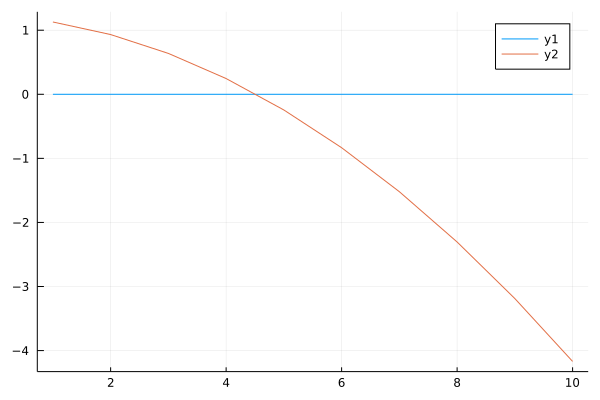

In [238]:
# Test the foot coords. The description for both is from the vertical
begin
    l = 1.0
    t1 = 0.0
    t2 = 0.0
    x0 = [-l/2*sin(t1); 1.22625; t1; t2; 0.0; 0.0; 0.0; 0.0]
    println(x0)
    hopper = Hopper(1, 1)
    fx = foot_coords(hopper, x0)
    h = 0.1
    # regCoords = foot_coords(hopper, fx)
    # println(fx)
    u = [0.0; 0.0; 0.0; 0.0]
    λ = zeros(2)
    ts = 10
    x = x0
    xVals = zeros(ts, length(x))
    for i = 1:ts
        newX, newL = implicit_euler_solve(hopper, x, u, λ, h; inair=true)
        λ = newL
        x = newX
        xVals[i, :] = x
        println(x)
        # println(foot_coords(hopper, x))
    end
    # println(xVals[end, :])
    # plot(xVals[:, 1], xVals[:, 2])
    # println(xVals[end, 2])
    plot(1:ts, xVals[:, 1])
    plot!(1:ts, xVals[:, 2])
    
end

In [4]:
# Testing for any sort of flight
begin
    x0 = [0; 0; 3*pi/4; -pi/2; 0; 0; 0; 0]
    # u0 = 2
    h = 0.1
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    x = x0
    # println(x)
    acon = -10
    bcon = -10
    for i = 1:20
        for j = 1:20
            newX = copy(x0)
            u = [acon, bcon]
            acon += 1
            bcon += 1
            rk4_dynamics!(hopper, newX, u, true, h)
            # println(newX[2])
            if (newX[2] >= 0)
                println(u)
                println(newX[1])
                println(newX[2])
            end
        end
    end
end

LoadError: MethodError: no method matching Hopper(::Int64, ::Int64, ::Int64, ::Float64, ::Float64)
Closest candidates are:
  Hopper(::Any, ::Any) at In[2]:4

## Stance and flight test with random control input

## Equilibrium Point Test

In [7]:
function equilibrium(hopper, x, uguess, ballistic, params)
    ueq = copy(uguess)
    λ = zeros(2)
    
    c = discrete_dynamics_hop(hopper, x0, ueq, false)[params]
    dfdb = ForwardDiff.jacobian(u->discrete_dynamics_hop(hopper, x0, u, ballistic), ueq)
    reldb = dfdb[params, :]
    gradb = (ueq - uguess) + reldb' * λ
    kkt_vec = [gradb; c]
    tol = 1e-4
    count = 1
    limit = 25
    
    while (norm(kkt_vec) > tol) && (count < limit)
        kkt_mat = [I(2)    reldb';
                   reldb   zeros(2, 2)]
        kkt_mat = kkt_mat .+ Diagonal([ones(2); -ones(2)])*1e-4
        deltas = -kkt_mat \ kkt_vec

        delU = deltas[1:length(uguess)]
        delλ = deltas[length(uguess)+1:end]
    
        ueq = ueq + delU
        λ = λ + delλ
        c = discrete_dynamics_hop(hopper, x0, ueq, false)[params]
        dfdb = ForwardDiff.jacobian(u->discrete_dynamics_hop(hopper, x0, u, false), ueq)
        reldb = dfdb[params, :]
        gradb = (ueq - uguess) + reldb' * λ
        kkt_vec = [gradb; c]
        count = count + 1
        # println(norm(kkt_vec))
    end
    # println(ueq)
    return ueq
end

equilibrium (generic function with 1 method)

## Testing Acrobot vs the Compass Gait  Dynamics

In [8]:
function dynamics_rk4(a,x,u,h)
    #RK4 integration with zero-order hold on u
    f1 = dynamics(a, x, u)
    f2 = dynamics(a, x + 0.5*h*f1, u)
    f3 = dynamics(a, x + 0.5*h*f2, u)
    f4 = dynamics(a, x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [9]:
# Start MeshCat
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\brand\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

## Equilibrium point testing and visualization

[-0.5, 3.061616997868383e-17, 1.5707963267948966, 1.5707963267948966, 0.0, 0.0, 0.0, 0.0]


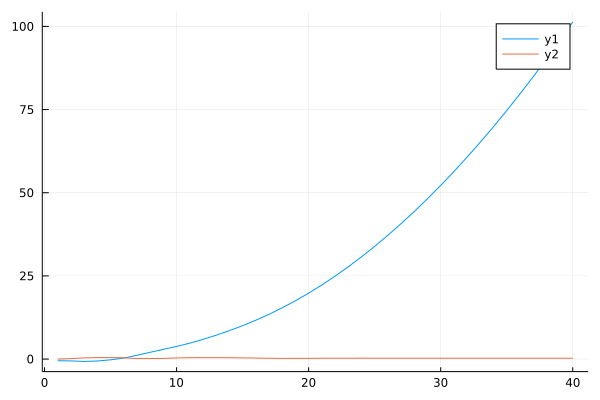

In [255]:
# Acrobot performance vs the Hopper: Acrobot version
begin
    a = RobotZoo.Acrobot()

    l = 1.0
    t1 = pi/2
    t2 = pi/2
    x0 = [-l/2*sin(t1); l/2*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]
    println(x0)
    hopper = Hopper(1, 1)
    fx = foot_coords(hopper, x0)
    h = 0.1

    u = [0.0; 0.0; 0.0; 0.0]
    λ = zeros(2)
    ts = 40
    x = x0
    Xs = zeros(ts, length(x))
    Xs[1, :] = x
    # Xs = zeros(N, 8)
    for i = 2:ts
        newX, newL = implicit_euler_solve(hopper, x, u, λ, h; inair=false)
        λ = newL
        x = newX
        Xs[i, :] = x
        # println(x)
    end
    # println(xVals[end, :])
    # plot(xVals[:, 1], xVals[:, 2])
    ths = [SVector{4}([pi/2 + Xs[i, 3]; Xs[i, 4]; Xs[i, 7]; Xs[i, 8]]) for i = 1:T]
    TrajOptPlots.set_mesh!(vis, a)
    visualize!(vis, a, T*h, ths)
    plot(1:ts, Xs[:, 1])
    plot!(1:ts, Xs[:, 2])
end

# Controls Part: Solving an NLP using IPOPT
We want to formulate the problem as follows:
$$ min_{z=1:N} \frac{1}{2}(z_{N}-z_{N, ref})^{T} Q_{N} (z_{N}-z_{N, ref}) + \sum \frac{1}{2}(z_{n}-z_{n, ref})^{T} Q_{n} (z_{n}-z_{n, ref}) + q_{n}^{T}(z_{n}-z_{n, ref})$$ 
where the combined $$ z = \begin{bmatrix} u_{1} \\ x_{2} \\ u_{2} \\ . \\ .\\ . \\ x_{N} \end{bmatrix}$$

To do this, we need to solve for the piece $c(z)$. The solver (IPOPT) should handle the rest for us.

$$c(z) = \begin{bmatrix} c_{dyn}\\ c_{\alpha} \\ c_{>0} \\ c_{y_{nref}} \\ c_{init} \\ c_{term}\end{bmatrix}$$
  
where
$$c_{>0} \rightarrow{} y_{ref} = 0 \text{ (in stance mode)}$$
$$c_{\alpha} \rightarrow{} \frac{\pi}{2} \leq \alpha \leq \pi$$
$$c_{y_{nref}} \rightarrow {} y_{nref} > y_{ref} $$
$c_{dyn}$ is the usual dynamics equality constraint

In [226]:
# Some useful functions
# Find the LQR cost of something
function LQRcost(nlp, Z)
    J = 0.0
    xinds, uinds = nlp.xinds, nlp.uinds
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    uf = zeros(length(U[1]))
    # Some useful constants
    c = 0.5*xf'*Q*xf + 0.5*uf'*R*uf
    q = -Q*xf
    r = -R*uf
    for i = 1:nlp.N-1
        x = Z[xinds[i]]
        u = Z[uinds[i]]
        # Stage cost
        J += 0.5*(x'*Q*x + u'*R*u) + q'*x + r'*u + c
    end
    x = Z[xinds[end]]
    # Terminal cost
    J += 0.5*x'*Qf*x + q'*x + c
    return J
end


function cost_grad!(nlp, grad, Z)
    xinds, uinds = nlp.xinds, nlp.uinds
    Q = nlp.Q
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    N = nlp.N
    uf = zeros(length(uinds[1]))
    # Some useful constants
    q = -Q*xf
    r = -R*uf
    for i = 1:N-1
        x, u = Z[xinds[i]], Z[uinds[i]]
        grad[xinds[i]] .= Q*x + q
        grad[uinds[i]] .= R*u + r
    end
    grad[xinds[end]] .= Qf*Z[xinds[end]] + q
    return nothing
end
    

function unpack(nlp, Z)
    # println(size(Z))
    X = [Z[inds] for inds in nlp.xinds]
    U = [Z[inds] for inds in nlp.uinds]
    λ = [Z[inds] for inds in nlp.linds]
    return X, U, λ
end



function pack(nlp, X, U, λ)
    # println(nlp.N)
    # println(λ)
    Z = zeros(nlp.N*length(X[1]) + (nlp.N - 1)*length(U[1]) + (nlp.N-1)*length(λ[1]))
    # println(length(Z))
    for i = 1:nlp.N-1
        Z[nlp.xinds[i]] .= X[i]
        Z[nlp.uinds[i]] .= U[i]
        Z[nlp.linds[i]] .= λ[i]
    end
    Z[nlp.xinds[end]] .= X[end]
    # Z[nlp.linds[end]] .= λ[end]
    return Z
end
        
        

# First, we want to define the problem. The length of z is going to be 10*N
struct HybridNLP <: MOI.AbstractNLPEvaluator
    model       # dynamics model, hopper
    Q           # x cost matrix
    R           # u cost matrix
    Qf          # xf terminal cost
    x0          # initial condition
    xf          # terminal condition
    mSteps      # number of timesteps in each mode
    modes       # vector of modes of each thing 
    zL          # lower bounds on primals
    zU          # upper bounds on primals
    lb          # lower bounds on constraints
    ub          # upper bounds on constraints
    xinds       # indices of x values
    uinds       # indices of u values
    linds       # indices of lambdas
    cinds       # indices of constraints
    tf          # final time
    N           # number of knot points
    h           # timestep
    function HybridNLP(model, Q, R, Qf, tf, N, mSteps, x0, xf, h; fStart=false)
        xLen = 8
        uLen = 4
        lLen = 2
        zLen = xLen + uLen + lLen
        # Indexes of x and u, given zLen = xLen + uLen
        xinds = [SVector{xLen}((i-1)*(zLen) .+ (1:xLen)) for i=1:N]
        uinds = [SVector{uLen}((i-1)*(zLen) .+ ((xLen+1):(xLen+uLen))) for i=1:N-1]
        linds = [SVector{lLen}((i-1)*(zLen) .+ ((xLen+uLen+1):(zLen))) for i=1:N-1]
#         println(xinds)
#         println(uinds)
#         println(linds)
        # Calculate hybrid method modes
        modes = zeros(N)
        if fStart
            change = -1
            curMode = 2
        else
            change = 1
            curMode = 1
        end
        
        for i = 1:N
            modes[i] = curMode
            if mod(i, mSteps) == 0
                curMode += change
                change = -change
            end
        end
        
        # Constraint indexing
        cDInds = 1:(xLen*(N - 1))
        # Correct this to match the 1 or 2 constraints depending on the setup
        cStanceInds = (xLen*(N - 1) + N + 1):(xLen*(N - 1) + 2*N)
#         cHeadInds = (xLen*(N - 1) + 2*N + 1):(xLen*(N - 1) + 3*N)
        cInitInds = (xLen*(N - 1) + 2*N + 1):(xLen*N + 2*N)
        cTermInds = (xLen*N + 2*N + 1):(xLen*(N + 1) + 2*N)
        cinds = [cDInds, cStanceInds, cInitInds, cTermInds] # cAInds, cHeadInds, cInitInds, cTermInds]
        
        lb = zeros(cinds[end][end])
        ub = zeros(cinds[end][end])
        
        # Bound values of alpha
#         lb[cAInds] .= pi/2
#         ub[cAInds] .= pi
#         # Lower and upper bound the height for non-foot
#         lb[cHeadInds] .= 0.25
#         ub[cHeadInds] .= 1.75
        
        # Calculate the number of primal variables
        num_prim = xLen*N + uLen*(N-1)
        zL = fill(-Inf, num_prim)
        zU = fill(Inf, num_prim)
        
        new(model, Q, R, Qf, x0, xf, mSteps, modes, zL, zU, lb, ub, xinds, uinds, linds, cinds, tf, N, h)
    end
end

In [227]:
# Test the HybridNlp formulator
begin
    uSize = 4
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    xf = zeros(xSize)
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
    
    hopper = Hopper(1, 1)
    h = 0.1
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = [0.0 0.0 0.0 0.0;
         0.0 0.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    N = 5
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h)
    
    # Test pack

    X = [SVector{8}(x0 .+ 1) for i=1:N]
    U = [SVector{4}(u0 .- 1) for i=1:N-1]
    λ = [SVector{2}(λ0) for i=1:N-1]
    # println(N*length(X[1]) + (N - 1)*length(U[1]))
    Z = pack(p, X, U, λ)
    println("Packed Zs: ", length(Z))
    rX, rU, rL = unpack(p, Z)
    println("Unpacked Xs: ", rX)
    println("Unpacked Us: ", rU)
    println("Unpacked λs: ", rL)
    J = LQRcost(p, Z)
    println("Cost: ", J)
    cG = zeros(length(x0)*N + length(u0)*(N-1) + length(λ0)*(N-1))
    cost_grad!(p, cG, Z)
    println("Cost Gradient: ", cG)
    # println(p.lb)
    println(length(p.lb))
    println(p.cinds[end][end])
end

Packed Zs: 64
Unpacked Xs: SArray{Tuple{8},Float64,1,8}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
Unpacked Us: SArray{Tuple{4},Float64,1,4}[[-1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0], [-1.0, -1.0, -1.0, -1.0]]
Unpacked λs: SArray{Tuple{2},Float64,1,2}[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
Cost: 4.2
Cost Gradient: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
58
58


In [281]:
# Dynamics constraint, want 5 in stance and 5 in flight. Jump map is on flight's number 5
function dynamics_constraints(nlp, Z::AbstractVector, c::AbstractVector)
    X, U, λ = unpack(nlp, Z)
    N = nlp.N
    h = nlp.h
    modes = nlp.modes
    xLen = length(X[1])
    d = reshape(view(c, nlp.cinds[1]), xLen, N-1)
    
    for i = 1:N-1
        mode = modes[i]
        if mod(i, 5) == 0
            d[:, i] .= jump_map(implicit_euler_dynamics(nlp.model, X[i], X[i+1], U[i], λ[i], h)) - X[i+1]
        else
            d[:, i] .= implicit_euler_dynamics(nlp.model, X[i], X[i+1], U[i], λ[i], h) - X[i+1]
        end
    end
    return d # checking is easier
end


function alpha_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    a = reshape(view(c, nlp.cinds[2]), N)
    # println(a)
    for i = 1:N
        x = X[i]
        a[i] = x[3]
    end
    return a
end


function stance_constraints(nlp, Z, c)
    X, U, λ = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    sInds = nlp.cinds[2]
    s = reshape(view(c, sInds), length(sInds))
    count = 1
    while (count < length(sInds))
        if modes[count] == 1
            x = X[count]
            fcoords = foot_coords(nlp.model, x)
            s[count] = fcoords[2]
        else
            l = λ[count]
            s[count] = l[1]^2 + l[2]^2
        end
        count = count + 1
    end
    x = X[end]
    fcoords = foot_coords(nlp.model, x)
    s[end] = fcoords[2]
    return s
end


function head_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    y = reshape(view(c, nlp.cinds[4]), N)
    for i = 1:N
        x = X[i]
        fx = foot_coords(nlp.model, x)
        y[i] = fx[2] - x[2]
    end
    return y
end


function init_term_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    n = length(X[1])
    modes = nlp.modes
    # N = nlp.N
    init = reshape(view(c, nlp.cinds[3]), n)
    term = reshape(view(c, nlp.cinds[4]), n)
    init .= X[1] - nlp.x0
    term .= X[end] - nlp.xf
    return init, term
end


function constraints!(nlp, Z, c)
    dynamics_constraints(nlp, Z, c)
#     alpha_constraints(nlp, Z, c)
#     stance_constraints(nlp, Z, c)
#     head_constraints(nlp, Z, c)
#     init_term_constraints(nlp, Z, c)
end

constraints! (generic function with 1 method)

In [207]:
# Constraints tests
begin
    uSize = 4
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    xf = zeros(xSize)
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
    
    hopper = Hopper(1, 1)
    h = 0.1
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = [0.0 0.0 0.0 0.0;
         0.0 0.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    N = 10
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h)
    
    # Xref, Uref = ref_traj(p, 0.1)
    X = [SVector{8}(x0) for i=1:N]
    U = [SVector{4}(u0 .- 1) for i=1:N-1]
    λ = [SVector{2}(λ0 .+ 0.1) for i=1:N-1]
    # println(N*length(X[1]) + (N - 1)*length(U[1]))
    Z = pack(p, X, U, λ)
    # Z = pack(p, Xref, Uref)
    c = zeros(num_duals(p))
    println("c: ",length(c))
    constraints!(p, Z, c)
    println("Dynamics Constraints")
    println(c[p.cinds[1]])
    println(p.lb[p.cinds[1]])
    # println("Alpha Constraints")
    # println(c[p.cinds[2]])
    # println(p.lb[p.cinds[2]])
    println("Stance Constraints")
    println(c[p.cinds[2]])
    println(p.lb[p.cinds[2]])
    # println("Head Constraints")
    # println(c[p.cinds[4]])
    # println(p.lb[p.cinds[4]])
    println("Init Term Jac")
    println(c[p.cinds[3]])
    println(c[p.cinds[4]])
end

c: 108
Dynamics Constraints
[0.0, 0.0, 0.0, 0.0, -0.010000000000000002, -0.976, -0.05636363636363637, -0.06363636363636364, 0.0, 0.0, 0.0, 0.0, -0.010000000000000002, -0.976, -0.05636363636363637, -0.06363636363636364, 0.0, 0.0, 0.0, 0.0, -0.010000000000000002, -0.976, -0.05636363636363637, -0.06363636363636364, 0.0, 0.0, 0.0, 0.0, -0.010000000000000002, -0.976, -0.05636363636363637, -0.06363636363636364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.05636363636363637, -0.06363636363636364, 0.0, 0.0, 0.0, 0.0, -0.010000000000000002, -0.976, -0.05636363636363637, -0.06363636363636364, 0.0, 0.0, 0.0, 0.0, -0.010000000000000002, -0.976, -0.05636363636363637, -0.06363636363636364, 0.0, 0.0, 0.0, 0.0, -0.010000000000000002, -0.976, -0.05636363636363637, -0.06363636363636364, 0.0, 0.0, 0.0, 0.0, -0.010000000000000002, -0.976, -0.05636363636363637, -0.06363636363636364]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [282]:
# Put together the Jacobians
function dynamics_jacobian(nlp, Z)
    # x = Z[nlp.xinds[1]]
    # println(zeros(eltype(x), nlp.cinds[end][end]))
    return ForwardDiff.jacobian(z->vec(dynamics_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function alpha_jacobian(nlp, Z)
    # c = zeros(eltype(z), nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->vec(alpha_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function stance_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->vec(stance_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function head_jacobian(nlp, Z)
    return ForwardDiff.jacobian(z->vec(head_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function init_term_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->init_term_constraints(nlp, z, zeros(eltype(z), num_duals(nlp))), Z)
end


function constraint_jacobian!(nlp, Z, jac)
    d_jac = dynamics_jacobian(nlp, Z)
#     # s_jac = stance_jacobian(nlp, Z)
    
#     xLen = length(nlp.xinds[1])
#     it_jac = zeros(2*xLen, num_primals(nlp))
#     # println(size(it_jac))
#     it_jac[1:xLen, nlp.xinds[1]] .= I(xLen)
#     it_jac[(end-xLen+1):end, nlp.xinds[end]] .= I(xLen)
#     # jac_term = view(jac, nlp.cinds[5], nlp.xinds[end])
    
    jac[nlp.cinds[1], :] .= d_jac
    # jac[nlp.cinds[2], :] .= s_jac
    # jac[nlp.cinds[3], nlp.xinds[1]] .= I(xLen)
    # jac[nlp.cinds[4], nlp.xinds[end]] .= I(xLen)
    
    return nothing
end

constraint_jacobian! (generic function with 1 method)

In [283]:
# Jac Test
begin
    uSize = 4
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    xf = zeros(xSize)
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
    
    hopper = Hopper(1, 1)
    h = 0.1
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = [0.0 0.0 0.0 0.0;
         0.0 0.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    N = 10
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h)
    
    # Xref, Uref = ref_traj(p, 0.1)
    X = [SVector{8}(x0) for i=1:N]
    U = [SVector{4}(u0 .- 1) for i=1:N-1]
    λ = [SVector{2}(λ0 .+ 0.1) for i=1:N-1]

    Z = pack(p, X, U, λ)
    m_nlp = num_duals(p)
    n_nlp = num_primals(p)
    mjac = zeros(m_nlp, n_nlp)
    println("m", m_nlp)
    println("n", n_nlp)
    # println(dynamics_jacobian(p, Z))
    constraint_jacobian!(p, Z, mjac)
    println(mjac)
    # println(ForwardDiff.jacobian((x,c) -> constraints!(p, x, c), Z, zeros(m_nlp)))
    # ForwardDiff.jacobian!(mjac, (x,c) -> constraints!(p, x, c), Z, zeros(m_nlp))
    # println(size(mjac))
    # println(mjac)
    
    
#     println("Constraint Jacobian")
#     println(jump_map(rk4_dynamics(p.model, X[1], U[1], false, h)))
#     println(X[2])
#     constraints!(p, Z, c, h)
   
#     println(p.lb[p.cinds[1]])
#     println("Alpha Constraints")
#     println(c[p.cinds[2]])
#     println(p.lb[p.cinds[2]])
#     println("Stance Constraints")
#     println(c[p.cinds[3]])
#     println(p.lb[p.cinds[3]])
#     println("Head Constraints")
#     println(c[p.cinds[4]])
#     println(p.lb[p.cinds[4]])
#     println("Init Constraints")
#     println(c[p.cinds[5]])
#     println(p.lb[p.cinds[5]])
#     println("Term Constraints")
#     println(c[p.cinds[6]])
#     println(p.lb[p.cinds[6]])
end

m108
n134


[1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 -0.004363636363636364 0.06836363636363636 0.0036363636363636372 0.0 0.0 0.0 0.021785454545454542 -0.33446909090909094 0.0 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.06836363636363638 -0.004363636363636364 0.07636363636363636 0.0 0.0 0.0 -0.3413054545454545 0.02134909090909091 0.0 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 -0.004363636363636364 0.06836363636363636 0.0036363636

0.0 0.0 0.0 -0.039939999999999996 -0.03914000000000001 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.05 0.0 0.0 -0.007045454545454547 -0.007954545454545455 0.0 -1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [277]:
function num_duals(nlp)
    return nlp.cinds[end][end]
end

function num_primals(nlp)
    return nlp.N*8 + (nlp.N - 1)*4 + (nlp.N - 1)*2
end

# IPOPT Guts, borrowed from MOI.jl

function MOI.eval_objective(prob::HybridNLP, x)
    return LQRcost(prob, x)
end

function MOI.eval_objective_gradient(prob::HybridNLP, grad_f, x)
    cost_grad!(prob, grad_f, x)
    return nothing
end

function MOI.eval_constraint(prob::HybridNLP, g, x)
    constraints!(prob, x, g)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::HybridNLP, vec, x)
    m_nlp = num_duals(prob)
    n_nlp = num_primals(prob)
    jac = reshape(vec, m_nlp, n_nlp)
    # ForwardDiff.jacobian!(jac, (x,c) -> constraints!(prob, x, c), x, zeros(m_nlp))
    constraint_jacobian!(prob, x, jac)
    return nothing
end

function MOI.features_available(prob::HybridNLP)
    return [:Grad, :Jac]
end

MOI.initialize(prob::HybridNLP, features) = nothing
MOI.jacobian_structure(nlp::HybridNLP) = vec(Tuple.(CartesianIndices(zeros(num_duals(nlp), num_primals(nlp)))))

"""
    solve(x0, nlp::HybridNlp; tol, c_tol, max_iter)

Solve the NLP `nlp` using Ipopt via MathOptInterface, providing `x0` as an initial guess.

# Keyword Arguments
The following arguments are sent to Ipopt
* `tol`: overall optimality tolerance
* `c_tol`: constraint feasibility tolerance
* `max_iter`: maximum number of solver iterations
"""
function solve(x0,prob::HybridNLP;
        tol=1.0e-2,c_tol=1.0e-2,max_iter=10000)
    n_nlp, m_nlp = num_primals(prob), num_duals(prob)
    x_l, x_u = fill(-Inf,n_nlp), fill(+Inf,n_nlp)
    c_l, c_u = prob.lb, prob.ub

    println("Creating NLP Block Data...")
    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    has_objective = true
    block_data = MOI.NLPBlockData(nlp_bounds, prob, has_objective)

    println("Creating Ipopt...")
    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol
    solver.options["check_derivatives_for_naninf"] = "yes"

    x = MOI.add_variables(solver, n_nlp)

    println("Adding constraints...")
    for i = 1:n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    println("starting Ipopt Solve...")
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res, solver
end

solve

# Reference Trajectory: Find a good one

Let's go ahead and try to do a reference trajectory based on the sine wave first. Just hop in place this time, so we have

\begin{align*} 
x_{foot}     &= 0.0\\
y_{foot}     &= y_{max} - y_{max}\cos(\frac{\pi}{5}N)\\
\alpha       &= \frac{3\pi}{4} - \frac{\pi}{6}(1 - \cos(\frac{\pi}{5}N)) \\
\beta        &= -\frac{\pi}{2} + \frac{\pi}{6}(1 - \cos(\frac{\pi}{5}N))  \\
v_{x_{foot}} &= 0.0\\
v_{y_{foot}} &= y_{max}\frac{\pi}{5}\sin(\frac{\pi}{5}N)\\
d\alpha      &= -\frac{\pi^{2}}{30}\sin(\frac{\pi}{5}N) \\
d\beta       &= -d\alpha\\
\end{align*}
Make sure to 0 out the terminal velocity, should be up and down

We can compute forward diffs on the 
Note: knot points N should be a multiple of 5

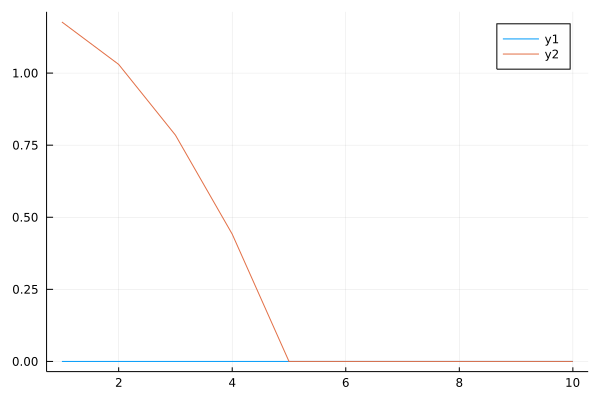

In [279]:
begin
    uSize = 4
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    x0[2] = 1.22625
    xf = zeros(xSize)
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
    
    N = 10
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h; fStart=true)
    gindex = zeros(xSize)
    gindex[2] = 1.0
    # Xref, Uref = ref_traj(p, 0.1)
    X = [SVector{8}(max.(x0 .- gindex*9.81/2*(h*i)^2, 0.0)) for i=1:N]
    U = [SVector{4}(u0) for i=1:N-1]
    λ = [SVector{2}(λ0) for i=1:N-1]

    Z = pack(p, X, U, λ)
    m_nlp = num_duals(p)
    n_nlp = num_primals(p)
    plot(X, inds=1:2)
    
end

In [ ]:
function ref_traj(nlp, ymax)
    N = nlp.N
    xLen = length(nlp.xinds[1])
    uLen = length(nlp.uinds[1])
    
    xref = zeros(xLen, N)
    uref = zeros(uLen, N-1)
    
    ueq = [123.0, 123.0]
    for i = 1:(N-1)
        t = i - 1
        xref[1, i] = 0.0
        xref[2, i] = ymax - ymax*cos(t*pi/5)
        xref[3, i] = 3*pi/4 - pi/6*(1 - cos(t*pi/5))
        xref[4, i] = -pi/2 + pi/6*(1 - cos(t*pi/5))
        xref[5, i] = 0.0
        xref[6, i] = (ymax*pi/5)*sin(pi/5*t)
        xref[7, i] = -((pi^2)/30)*sin((pi/5)*t)
        xref[8, i] = ((pi^2)/30)*sin((pi/5)*t)
        if mod(i, nlp.mSteps) == 1
            uref[:, i] .= ueq
        end
    end
    xref[:, end] .= nlp.xf
    Xref = [SVector{xLen}(x) for x in eachcol(xref)]
    Uref = [SVector{uLen}(u) for u in eachcol(uref)]
    return Xref, Uref
end

In [ ]:
# Testing the reference trajectory
begin
    x0 = zeros(8)
    x0[3] = 3*pi/4
    x0[4] = -pi/2
    xf = x0
    u0 = zeros(2)
    hopper = Hopper(1, 2, 1, 0.5, 0.5)
    tf = 10.0
    mSteps = 5
    Qf = I(8)
    Q = Qf * 0.01
    R = I(2) * 0.01
    N = 30
    
    p = HybridNlp(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, 0.1)
    xtraj, utraj = ref_traj(p, 0.1)
    p1 = plot(xtraj, inds=1:2, labels="positions")
    # plot!(xtraj, inds=2, labels="y")
    plot!(xtraj, inds=5:6, labels="velocities")
    # plot!(xtraj[6, :], labels="dy")
    # plot(x)
    p2 = plot(xtraj, inds=3:4, labels="angles")
    plot!(xtraj, inds=7:8, labels="ang vel")
    # plot!(a+b)
    # plot!(xtraj[7, :], labels="da")
    # plot!(xtraj[8, :], labels="db")
    println(utraj[7])
    plot(p1, p2, layout = (2, 1), legend = true)
end

Creating NLP Block Data...
Creating Ipopt...
Adding constraints...
starting Ipopt Solve...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    14472
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

The Jacobian for the equality constraints contains an invalid number

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 1
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 0
Total CPU secs in IPOPT (w/o function evaluations)   =      0.065
Total CPU

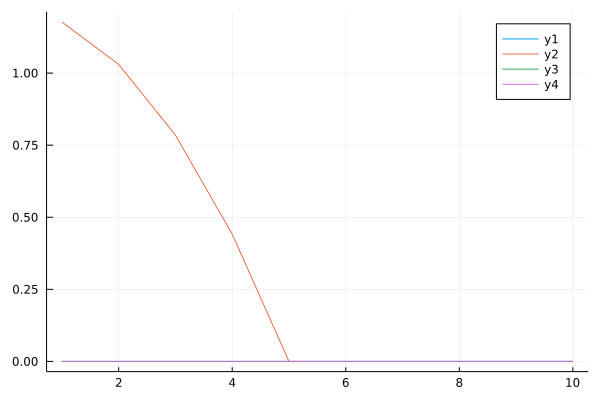

In [284]:
# Run the solver
begin
    uSize = 4
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    x0[2] = 1.22625
    xf = zeros(xSize)
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
     
    h = 0.1
    N = 10
    mSteps = 5
    tf = N*h
    
    Qf = I(8) * 0.01
    Q = Qf
    R = [0.0 0.0 0.0 0.0;
         0.0 0.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    
    hopper = Hopper(1, 1)
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h, fStart=true)

    gindex = zeros(xSize)
    gindex[2] = 1.0

    X = [SVector{8}(max.(x0 .- gindex*9.81/2*(h*i)^2, 0.0)) for i=1:N]
    U = [SVector{4}(u0) for i=1:N-1]
    λ = [SVector{2}(λ0) for i=1:N-1]

    Zref = pack(p, X, U, λ)

    Zout, solver = solve(Zref, p, c_tol=1e-1, tol=1e-2)
    Xout, Uout = unpack(p, Zout)
    plot(Xout, inds=1:4)
    # println(Xout)
end